In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import copy

from keras import Model, Sequential
from keras.optimizers import  Adam
from keras.layers import Dense, LSTM, Input
from keras.callbacks import LearningRateScheduler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.utils import to_categorical

In [2]:
def scheduler(epoch, lr):
  return .0001

def normalize(vec):
    max_val = max(vec)
    min_val = min(vec)
    return (vec - min_val) / (max_val - min_val)


class FederatedModel(Model):

  def __init__(self, T):
    super(FederatedModel, self).__init__()
    self.lstm1 = LSTM(100, input_shape=(T, len(feature_cols)), name='lstm1')
    self.dense1 = Dense(100, name='dense1')
    self.dense2 = Dense(1, activation='sigmoid', name='dense2')

  def call(self, inputs):
    x = self.lstm1(inputs)
    x = self.dense1(x)
    x = self.dense2(x)
    return x

In [3]:
df = pd.read_csv('data/trace/trace_avg.csv')
MAX_COST = 175
df = df[df['Cost'] < MAX_COST]
df['Cost'] = df['Cost'] / MAX_COST
fog_idxs = np.array(np.unique(df['Fog node']), dtype=np.int32)

df['Long'] = normalize(df['Long'])
df['Lat'] = normalize(df['Lat'])
df['CosTime'] = np.cos(df['TimeMin']/(60*24))
df['SinTime'] = np.sin(df['TimeMin']/(60*24))
feature_cols = ['Fog node', 'Long', 'Lat', 'CosTime', 'SinTime', 'Cost']
label_cols = ['Cost']

In [4]:
T = 10
DRIFT = True

x_train_fog = []
x_test_fog = []
y_train_fog = []
y_test_fog = []

if DRIFT:
    df.loc[df['Fog node'] == 7, 'Cost'] += 0.5

for idx in fog_idxs:
    inputrow = []
    outputrow = []
    for counter in range(0, len(df[df['Fog node'] == idx])-T-1):
        inputrow.append(np.array(df[df['Fog node'] == idx][feature_cols].iloc[counter:counter+T, :]))
        inputrow[-1][-1, -1] = 0.0
        outputrow.append(np.array(df[df['Fog node'] == idx][label_cols].iloc[counter+T-1, :]))
    inputdf = np.array(inputrow)
    outputdf = np.array(outputrow)
    x_train_fog.append(np.float32(inputdf))
    y_train_fog.append(np.float32(outputdf))
    # cutoff = int(0.80*len(inputdf))
    # x_train_fog.append(np.float32(inputdf[0:cutoff]))
    # x_test_fog.append(np.float32(inputdf[cutoff:len(inputdf)]))
    # y_train_fog.append(np.float32(outputdf[0:cutoff]))
    # y_test_fog.append(np.float32(outputdf[cutoff:len(outputdf)]))

In [5]:
local_models = [FederatedModel(T) for _ in fog_idxs]
for local_model in local_models:
    local_model.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [6]:
GLOBAL_EPOCHS = 10
LOCAL_EPOCHS = 3
VERBOSE = False
BATCH_SIZE = 32

loss = []
[loss.append([]) for _ in fog_idxs]

for epoch in range(GLOBAL_EPOCHS):
    for idx in fog_idxs:
        err = local_models[idx-1].evaluate(x_train_fog[idx-1], y_train_fog[idx-1], verbose=True)
        local_models[idx-1].fit(x_train_fog[idx-1], y_train_fog[idx-1], epochs=LOCAL_EPOCHS, verbose=VERBOSE, batch_size=BATCH_SIZE)
        loss[idx-1].append(err)

31/31 [==============================] - 0s 2ms/step - loss: 0.0362 - mae: 0.1347


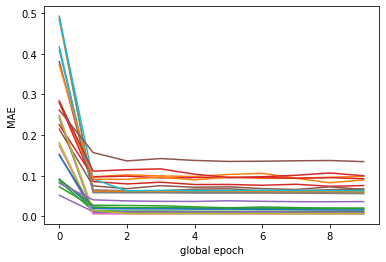

In [7]:
for l in loss:
    plt.plot(np.arange(len(l)), l)
    
plt.xlabel('global epoch')
plt.ylabel('MAE')
plt.title('')
plt.show()

In [8]:
global_model = FederatedModel(T)
global_model.compile(loss='mae', optimizer='adam')

In [9]:
GLOBAL_EPOCHS = 20
LOCAL_EPOCHS = 3
BATCH_SIZE = 32

loss = []
[loss.append([]) for _ in fog_idxs]

for epoch in range(GLOBAL_EPOCHS):
    for idx in fog_idxs:
        err = global_model.evaluate(x_train_fog[idx-1], y_train_fog[idx-1], verbose=False)
        loss[idx-1].append(err)
        global_model.fit(x_train_fog[idx-1], y_train_fog[idx-1], epochs=LOCAL_EPOCHS, verbose=False, batch_size=BATCH_SIZE)

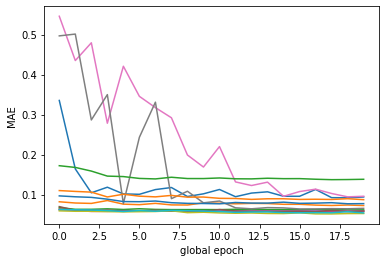

In [10]:
for l in loss:
    plt.plot(np.arange(len(l)), l)

plt.xlabel('global epoch')
plt.ylabel('MAE')
plt.title('')
plt.show()